### State-level Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [1]:
%%HTML
<div class='tableauPlaceholder' id='viz1615415203473' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;SP&#47;SPYJ96S9Y&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;SPYJ96S9Y' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;SP&#47;SPYJ96S9Y&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1615415203473');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='800px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='800px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='1527px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [4]:
testing = pd.read_json('https://jhucoronavirus.azureedge.net/api/v1/testing/daily.json')
testing.shape

(20892, 10)

In [5]:
testing.head()

,date,state,people_viral_positive,tests_viral_positive,tests_viral_negative,encounters_viral_total,tests_viral_total,people_viral_total,tests_combined_total,cases_conf_probable
0,20200306,AK,NaN,NaN,NaN,NaN,8.0,NaN,8.0,NaN
1,20200307,AK,NaN,NaN,NaN,NaN,12.0,NaN,12.0,NaN
2,20200308,AK,NaN,NaN,NaN,NaN,14.0,NaN,14.0,NaN
3,20200309,AK,NaN,NaN,NaN,NaN,23.0,NaN,23.0,NaN
4,20200310,AK,NaN,NaN,NaN,NaN,23.0,NaN,23.0,NaN


In [6]:
testing['date'] = pd.to_datetime(testing.date,format='%Y%m%d')

In [7]:
texas_testing = testing[testing.state=='TX']
texas_testing.reset_index(drop=True,inplace=True)

In [11]:
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

texas_testing['Overall Positivity'] = texas_testing.cases_conf_probable/texas_testing.tests_viral_total*100
texas_testing['Overall Positivity Moving Average'] = \
        texas_testing['Overall Positivity'].rolling(7).mean()
texas_testing['daily_tests'] = texas_testing.tests_viral_total.diff()
texas_testing['daily_tests'] = [np.nan if x == 0 else x for x in texas_testing.daily_tests]
texas_testing['daily_positive'] = texas_testing.tests_viral_positive.diff()
texas_testing['daily_positivity_rate'] = texas_testing.daily_positive/texas_testing.daily_tests*100
texas_testing['Rolling Positivity Rate Average'] = \
    texas_testing.daily_positivity_rate.rolling(7).mean()
texas_testing['rolling_avg_tests'] = texas_testing.daily_tests.rolling(7).mean()
texas_testing['daily_people_positive'] = texas_testing.cases_conf_probable.diff()
texas_testing['rolling_avg_positives'] = texas_testing.daily_people_positive.rolling(7).mean()
texas_testing['JHU Rolling Positivity Rate'] = texas_testing.rolling_avg_positives/\
            texas_testing.rolling_avg_tests*100
texas_testing['weekly_tests'] = texas_testing.daily_tests.rolling(7).sum()
texas_testing['weekly_positives'] = texas_testing.daily_positive.rolling(7).sum()
texas_testing['Rolling Positivity Rate Absolute'] = texas_testing.weekly_positives/texas_testing\
            .weekly_tests*100

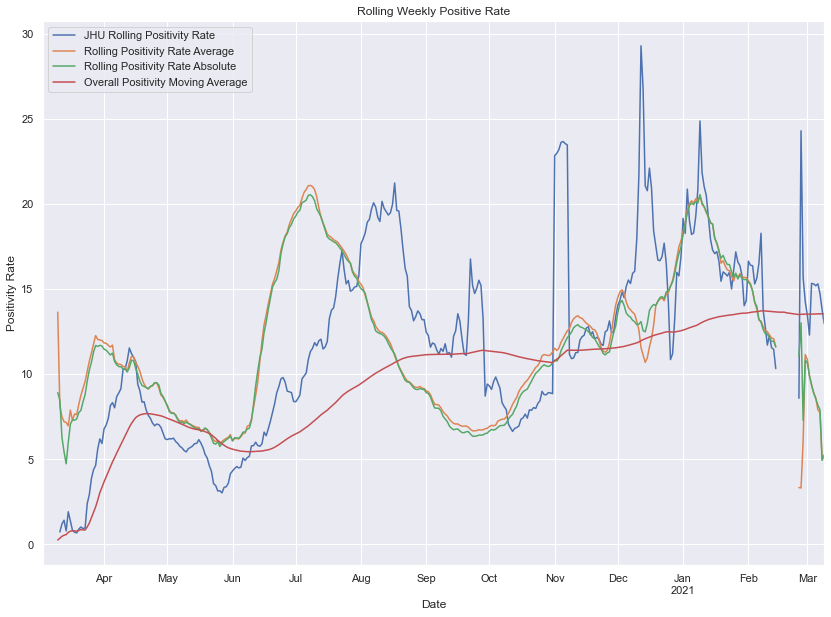

In [12]:
_ = texas_testing[['date','JHU Rolling Positivity Rate','Rolling Positivity Rate Average',
                   'Rolling Positivity Rate Absolute','Overall Positivity Moving Average']]\
    .plot(x='date', figsize=(14,10),
                title='Rolling Weekly Positive Rate', ylabel='Positivity Rate', xlabel='Date')
plt.savefig('PositivityRates.png')

### County-level Testing Data

- Daily tests

In [13]:
county_tests = pd.read_excel('https://dshs.texas.gov/coronavirus/TexasCOVID-19CumulativeTestsbyCounty.xlsx',
               header=1)
county_tests = county_tests.iloc[:254,:]

In [14]:
county_level = pd.DataFrame(columns=['Date','daily_tests','County'])
counter = 0
for county in county_tests.County:
    df = pd.DataFrame(county_tests[county_tests.County==county].T.reset_index().iloc[1:]\
        .rename(columns={'index':'Date',counter:'Cumulative Tests'}))
    df['daily_tests'] = df['Cumulative Tests'].diff()
    df['County'] = county
    df.drop(columns=['Cumulative Tests'], inplace=True)
    county_level = county_level.append(df)
    counter += 1
county_level['Date'] = pd.to_datetime(county_level.Date,format='%Y%m%d')
county_level['daily_tests'] = county_level['daily_tests'].fillna(0).astype('int64')

In [15]:
county_tests2 = pd.read_excel('https://dshs.texas.gov/coronavirus/TexasCOVID-19CumulativeTestsOverTimebyCounty.xlsx',
             header=1, na_values=['--','-'])
county_tests2 = county_tests2.iloc[:254,:]
df2 = pd.DataFrame(columns=['Date','daily_tests','County'])
counter = 0
for county in county_tests2.County:
    df = pd.DataFrame(county_tests2[county_tests2.County==county].T.reset_index().iloc[1:]\
        .rename(columns={'index':'Date',counter:'Cumulative Tests'}))
    df['daily_tests'] = df['Cumulative Tests'].diff()
    df['County'] = county
    df.drop(columns=['Cumulative Tests'], inplace=True)
    df2 = df2.append(df)
    counter += 1

In [16]:
df2['Date'] = df2.Date.str.replace('Tests Through ','')
months = {'April ':'04-','May ':'05-','June ':'06-','July ':'07-','August ':'08-','September ':'09-'}
for k in list(months.keys()):
    df2['Date'] = df2.Date.str.replace(k, months[k])
df2['Date'] = df2.Date.replace(months)
df2['Date'] = [x + '-2020' for x in df2.Date]
df2.dropna(subset=['daily_tests'],inplace=True)
df2['Date'] = pd.to_datetime(df2.Date)
df2['daily_tests'] = df2['daily_tests'].fillna(0).astype('int64')

In [17]:
county_level = county_level.append(df2)
county_level.sort_values(by=['County','Date'],inplace=True)
county_level.reset_index(drop=True,inplace=True)
county_level = pd.DataFrame(county_level, columns=['Date','County','daily_tests'])

- Probable positives

In [18]:
county_cases = pd.read_excel('https://dshs.texas.gov/coronavirus/TexasCOVID-19NewProbableCasesbyCounty.xlsx',
               header=2)
county_cases = county_cases.iloc[:254,:]

C:\Users\robin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [19]:
county_level2 = pd.DataFrame(columns=['Date','daily_probable','County'])
counter = 0
for county in county_cases.County:
    df = pd.DataFrame(county_cases[county_cases.County==county].T.reset_index().iloc[1:]\
        .rename(columns={'index':'Date',counter:'daily_probable'}))
    df['County'] = county
    county_level2 = county_level2.append(df)
    counter += 1
county_level2['Date'] = county_level2.Date.str.replace('New Probable ','')
county_level2['Date'] = pd.to_datetime(county_level2.Date)
county_level2['daily_probable'] = county_level2['daily_probable'].fillna(0).astype('int64')

In [20]:
county_level = county_level.merge(county_level2, how='left', on=['Date','County'])
county_level['daily_probable'] = county_level.daily_probable.fillna(0).astype('int64')

- Confirmed positives

In [21]:
county_cases = pd.read_excel('https://dshs.texas.gov/coronavirus/TexasCOVID-19NewCasesOverTimebyCounty.xlsx',
               header=2)
county_cases = county_cases.iloc[:254,:]

In [22]:
county_level2 = pd.DataFrame(columns=['Date','daily_confirmed','County'])
counter = 0
for county in county_cases.County:
    df = pd.DataFrame(county_cases[county_cases.County==county].T.reset_index().iloc[1:]\
        .rename(columns={'index':'Date',counter:'daily_confirmed'}))
    df['County'] = county
    county_level2 = county_level2.append(df)
    counter += 1
county_level2['Date'] = county_level2.Date.str.replace('New Cases ','')
county_level2['Date'] = pd.to_datetime(county_level2.Date)
county_level2['daily_confirmed'] = county_level2['daily_confirmed'].fillna(0).astype('int64')

In [23]:
county_level = county_level.merge(county_level2, how='left', on=['Date','County'])

- Positivity rate calculations

In [25]:
county_level['total_positives'] = county_level.daily_probable + county_level.daily_confirmed
county_level['positivity_rate'] = county_level.total_positives/county_level.daily_tests*100

In [26]:
import requests, zipfile, io
r = requests.get('https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(members=['2020_US_Region_Mobility_Report.csv'])

In [27]:
mobility = pd.read_csv('2020_US_Region_Mobility_Report.csv')

C:\Users\robin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
texas = mobility[mobility.sub_region_1 == 'Texas']

In [29]:
texas['sub_region_2'] = texas.sub_region_2.str.replace(' County', '')

In [30]:
texas = texas[['sub_region_1','sub_region_2','date','retail_and_recreation_percent_change_from_baseline',
              'grocery_and_pharmacy_percent_change_from_baseline',
              'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
              'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']]

In [31]:
texas.rename(columns={'sub_region_1':'State','sub_region_2':'County','date':'Date'},inplace=True)
texas = texas[texas.County.notnull()]
texas['Date'] = pd.to_datetime(texas.Date)

In [32]:
county_level = county_level.merge(texas, how='left', on=['Date','County'])

In [33]:
mobility_counties = list(texas.County.unique())
county_level = county_level[county_level.County.isin(mobility_counties)]

In [34]:
county_level.to_csv('MobilityCovid.csv')